In [88]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.weightstats import zconfint
import scipy

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv ('credit_card_default_analysis.csv', sep =',')

In [5]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
data.shape

(30000, 25)

# Задание 1.

In [13]:
data_def0 = data[data['default'] == 0]
data_def1 = data[data['default'] == 1]

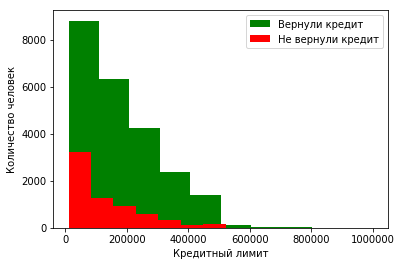

In [21]:
plt.hist (data_def0['LIMIT_BAL'], color='green', label=u'Вернули кредит')
plt.hist (data_def1['LIMIT_BAL'], color='red', label=u'Не вернули кредит')
plt.xlabel (u'Кредитный лимит')
plt.ylabel (u'Количество человек')
plt.legend()
plt.show()

На графике видно, что медиана распределения кредитного лимита у "Вернувших кредит" расположена правее, тк гистаграма имеет более тяжелый правый хвост

а) Равенство медианных значений будем считать методом "Бутстрепа", тк о распределениее нам ничего не известно.

In [31]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [32]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [57]:
np.random.seed(0)

def0_median_scores = map(np.median, get_bootstrap_samples(np.array(data_def0['LIMIT_BAL']), 1000))
def1_median_scores = map(np.median, get_bootstrap_samples(np.array(data_def1['LIMIT_BAL']), 1000))

In [58]:
print "95% confidence interval for median DEF = 0 ",  stat_intervals(def0_median_scores, 0.05)
print "95% confidence interval for median DEF = 1",  stat_intervals(def1_median_scores, 0.05)

95% confidence interval for median DEF = 0  [150000. 150000.]
95% confidence interval for median DEF = 1 [80000. 90000.]


На всякий случай проведем интервальную оценку на разность медиан

In [61]:
delta_median_scores = map(lambda x: x[0] - x[1], zip(def0_median_scores, def1_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [60000. 70000.]


Ответ 1_а:

Интевалы не пересекаются и медиана "Вернувших кредит" лежит полностью правее дефолтных клиентов. Медианы с 95% вероятностью не равны. Такой странный интервал для def=0 вероятно получился из за сильной дискретности в данных.

б) Равенство средних будем проверять с помощью рангового критерия Манна-Уитни

H0:FX1(x)=FX2(x)
 
H1:FX1(x)=FX2(x+Δ),Δ≠0

In [65]:
stats.mannwhitneyu(data_def0['LIMIT_BAL'], data_def1['LIMIT_BAL'])

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Ответ 2_б:   
    Равенство средних критерием Манна-Уитни полностью отвергается. С практической точки зрения результаты значимы, они говорят о том, что риски не на всех кредитных лимитах равнозначны.

# Задание 2.

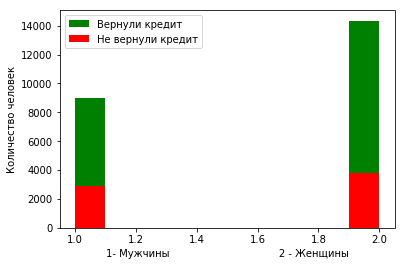

In [77]:
plt.hist (data_def0['SEX'], color='green', label=u'Вернули кредит')
plt.hist (data_def1['SEX'], color='red', label=u'Не вернули кредит')
plt.xlabel (u'1- Мужчины                                   2 - Женщины')
plt.ylabel (u'Количество человек')
plt.legend()
plt.show()

Гендерный состав может принимать только два значения, соответствено будем проверять теорию z-критерия для двух долей и построим доверительный интервал на их разность. Выборки не связанные.

In [82]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [83]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [84]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

Построим 95% доверительный интервал для разности долей:

In [90]:
p1 = data_def0['SEX'] -1 
p2 = data_def1['SEX'] -1 
print "95%% confidence interval for a difference between proportions: [%f, %f]" %proportions_diff_confint_ind (p1, p2)

95% confidence interval for a difference between proportions: [0.033635, 0.060548]


Интервал не содержит нуля, а это значит что с 95% вероятностью гендерный состав отличается.

Проверим гипотезу о том что гендерный состав одинаков, против двухсторонней гипотезы что не одинаков:

In [97]:
p_v1 = proportions_diff_z_test(proportions_diff_z_stat_ind(p1, p2))
print "p-value:= ", 
print p_v1

p-value:=  4.472866521609831e-12


С большой долей значимости гипотеза об одинаковости гендерносго состава отвергается.

# Задание №3

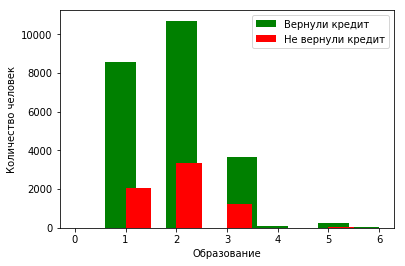

In [241]:
plt.hist (data_def0['EDUCATION'], color='green', label=u'Вернули кредит')
plt.hist (data_def1['EDUCATION'], color='red', label=u'Не вернули кредит')
plt.xlabel (u'Образование')
plt.ylabel (u'Количество человек')
plt.legend()
plt.show()

Проверим теорию о том, что образование не влияет на возврат долга, и попарно сравним количество вернувших/не вернувших долг со средним значением по всей выборке, не забыв при этом сделать поправку на множественную проверку гипотезы методом Бенжамини-Хохберта

In [187]:
p_val = []
for i in range (0,7):
    data_to_def = data[data['EDUCATION']==i]
    p_val.append(proportions_diff_z_test(proportions_diff_z_stat_ind(data['default'], data_to_def['default'])))

In [189]:
import statsmodels.stats.multitest as smm

In [190]:
p_val_tr = smm.multipletests (p_val, alpha = 0.5, method='fdr_bh')

In [192]:
print p_val_tr[1]

[5.38501008e-02 1.67208480e-09 2.25799311e-04 5.38238801e-06
 2.02306264e-05 1.67208480e-09 2.68621927e-01]


Ответ: Гипотеза о том, что наличие образование не влияет на, то вернет человек долг или нет, уверено отвергается по всем группам.

Составим таблицу сопряжености "образование" на "возврат долга", где значением ячейки будет разность между наблюдаемым оличеством человек и ожидаемым (те количеством человек в среднем для такого обьема не возвращяющих долг без учета образования)

Средний коэфицент людей не вовзращающих долг:

In [120]:
def1_count = float(data_def1.shape[0])
def0_count = float (data_def0.shape[0])
coef_def_1 = def1_count/(def1_count + def0_count)

Заполним два массивы с ожидаемыми количествами людей вернувших/не вернувших долг:

In [131]:
for i in range (0,7):
    if i == 0:
        educ_supposed_def_1 = np.array (round(data[data['EDUCATION']==i].count()[1]*coef_def_1))
        educ_supposed_def_0 = np.array(data[data['EDUCATION']==i].count()[1] - educ_supposed_def_1)
    else:
        educ_supposed_def_1 = np.append (educ_supposed_def_1,round(data[data['EDUCATION']==i].count()[1]*coef_def_1))
        educ_supposed_def_0 = np.append(educ_supposed_def_0,data[data['EDUCATION']==i].count()[1] - educ_supposed_def_1[i])

In [162]:
z = []
for i in range (0,7):
    z.append(np.array([i,educ_supposed_def_0[i] - data_def0[data_def0['EDUCATION']==i].count()[1], educ_supposed_def_1[i] - data_def1[data_def1['EDUCATION']==i].count()[1]]))
table1 = pd.DataFrame (z,columns = ['Education', 'Разница вернувших','Разница не вернувших' ])

Таблица сопряженности "образование" на "возврат долга":


In [166]:
table1

,Education,Разница вернувших,Разница не вернувших
0,0.0,-3.0,3.0
1,1.0,-305.0,305.0
2,2.0,227.0,-227.0
3,3.0,149.0,-149.0
4,4.0,-20.0,20.0
5,5.0,-44.0,44.0
6,6.0,-3.0,3.0


Можем нормировать разницу на обьем в каждой группе, в этом случае таблица будет такая:

In [177]:
z = []
for i in range (0,7):
    a = (educ_supposed_def_0[i] - data_def0[data_def0['EDUCATION']==i].count()[1])/data[data['EDUCATION']==i].count()[1]
    z.append(np.array([i,a,-a]))
table2 = pd.DataFrame (z,columns = ['Education', 'Разница вернувших,%','Разница не вернувших,%' ])

In [178]:
table2

,Education,"Разница вернувших,%","Разница не вернувших,%"
0,0.0,-0.214286,0.214286
1,1.0,-0.028814,0.028814
2,2.0,0.016180,-0.016180
3,3.0,0.030303,-0.030303
4,4.0,-0.162602,0.162602
5,5.0,-0.157143,0.157143
6,6.0,-0.058824,0.058824


Наилучшим индикатором того, что человек отдаст долг является наличие "Докторской" степени, а не отдаст долг с большой вероятностью "выпускник школы"

# Задание №4

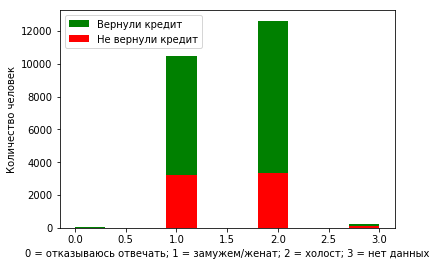

In [195]:
plt.hist (data_def0['MARRIAGE'], color='green', label=u'Вернули кредит')
plt.hist (data_def1['MARRIAGE'], color='red', label=u'Не вернули кредит')
plt.xlabel (u'0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных')
plt.ylabel (u'Количество человек')
plt.legend()
plt.show()

Измерим корреляцию параметра замужества и дуфолта. Для этого создадим отдельный бинарный признак холост или замужем/женат остальные данные отбросим (их очень мало), корреляцию будем проверять методом Мэтьюса

In [227]:
#Создадим таблицу сопряженнсоти
a = data[(data['MARRIAGE'] == 1)&(data['default'] == 0)].count()[1]
b = data[(data['MARRIAGE'] == 1)&(data['default'] == 1)].count()[1]
c = data[(data['MARRIAGE'] == 2)&(data['default'] == 0)].count()[1]
d = data[(data['MARRIAGE'] == 2)&(data['default'] == 1)].count()[1]

In [231]:
corr_matt = (a*d - b*c)/sqrt((a+b)*(a+c)*(b+d)*(c+d))
print corr_matt

-0.030555369920445503


Ответ 3:

Корреляция практически отсутствует, те с практической точки зрение этот вопрос можо убирать из анкеты? по крайней мере с точки зрения рисков не важно женат человек или холост.

# Задание №5

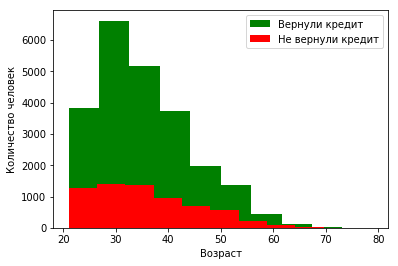

In [233]:
 plt.hist (data_def0['AGE'], color='green', label=u'Вернули кредит')
plt.hist (data_def1['AGE'], color='red', label=u'Не вернули кредит')
plt.xlabel (u'Возраст')
plt.ylabel (u'Количество человек')
plt.legend()
plt.show()

а) Равенство медианных значений будем считать методом "Бутстрепа", тк о распределениее нам ничего не известно.

In [234]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [235]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [236]:
np.random.seed(0)

def0_median_scores = map(np.median, get_bootstrap_samples(np.array(data_def0['AGE']), 1000))
def1_median_scores = map(np.median, get_bootstrap_samples(np.array(data_def1['AGE']), 1000))

In [237]:
print "95% confidence interval for median DEF = 0 ",  stat_intervals(def0_median_scores, 0.05)
print "95% confidence interval for median DEF = 1",  stat_intervals(def1_median_scores, 0.05)

95% confidence interval for median DEF = 0  [34. 34.]
95% confidence interval for median DEF = 1 [34. 35.]


In [238]:
delta_median_scores = map(lambda x: x[0] - x[1], zip(def0_median_scores, def1_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [-1.  0.]


Ответ 5_а:
Интевалы пересекаются. Отвергнуть теорию о равенстве медианы с 95% шансом мы не можем

б) Равенство средних будем проверять с помощью рангового критерия Манна-Уитни
H0:FX1(x)=FX2(x)
H1:FX1(x)=FX2(x+Δ),Δ≠0

In [240]:
stats.mannwhitneyu(data_def0['AGE'], data_def1['AGE'])

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Ответ 5_б:
Равенство средних критерием Манна-Уитни не отвергается. С практической точки зрения результаты значимы, они говорят о том, что риск примерно одинаков во всех возрастных категориях.